#### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

# random.seed(42)

In [2]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=15)

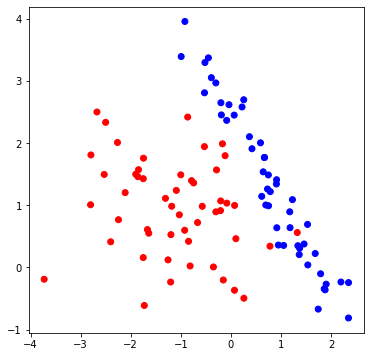

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))

plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

#### Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_lables = np.zeros(labels.shape)
#         mask= ...
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples - 1)
            b_data[j] = data[sample_index]
            b_lables[j] = labels[sample_index]
#             mask[j]
        bootstrap.append((b_data, b_lables))
    
    return bootstrap

In [5]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    random.shuffle(sample_indexes)
    for i in range(len(subsample)):
        subsample.append(sample_indexes.pop())
    
    return subsample

#### Построим дерево решений

In [6]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):

        classes = {} 
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
   
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
def gini(labels):

    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
def quality(left_labels, right_labels, current_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
def find_best_split(data, labels):
    
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    subsample = get_subsample(n_features)
    
    for index in subsample:
        
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

#### Сформируем случайный лес

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    boostrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in boostrap:
        forest.append(build_tree(b_data, b_labels))
    
    return forest

In [14]:
def classify_object(obj, node):
    
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

#### Голосование деревьев

In [16]:
def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    return voted_predictions

#### Разобьем выборку на обучающую и тестовую

In [17]:
from sklearn import model_selection
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                   classification_labels,
                                                                                   test_size=0.3,
                                                                                   random_state=1)

In [18]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100

#### Построим лес из 1 дерева

In [19]:
n_trees = [1, 3, 10, 50]

In [20]:
for n in n_trees:
    forest = random_forest(train_data, train_labels, n)
    train_answers = tree_vote(forest, train_data)
    test_answers = tree_vote(forest, test_data)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n} деревьев на обучающей выборке: {train_accuracy:.3f}\nТочность случайного леса из {n} деревьев на тестовой выборке: {test_accuracy:.3f}')
    print('-----------------------------------------------------------------')

Точность случайного леса из 1 деревьев на обучающей выборке: 51.429
Точность случайного леса из 1 деревьев на тестовой выборке: 43.333
-----------------------------------------------------------------
Точность случайного леса из 3 деревьев на обучающей выборке: 51.429
Точность случайного леса из 3 деревьев на тестовой выборке: 43.333
-----------------------------------------------------------------
Точность случайного леса из 10 деревьев на обучающей выборке: 51.429
Точность случайного леса из 10 деревьев на тестовой выборке: 43.333
-----------------------------------------------------------------
Точность случайного леса из 50 деревьев на обучающей выборке: 48.571
Точность случайного леса из 50 деревьев на тестовой выборке: 56.667
-----------------------------------------------------------------


#### Из-за малого размера датасета и количества признаков, значения точности получаются не очень хороими. Но при этом видно, что при увеличении количества деревьев точность предсказания на тестовой выборке становится выше (видно при 50 деревьях).

#### 2. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

#### 3. *(На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [21]:
def calc_entropy(labels):

    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity